# Pyrocko Notebook
## Double Couple Waveform Inversion (The 2009 Aquila Earthquake)

In this Jupyter-notebook we look at teleseismic waveforms of the 2009 Aquila Earthquake and setup `pyrocko.gf` forward modelling to invert for the double couple mechanism and also for the full moment tensor of the event. We will use `pyrocko` (https://pyrocko.org/docs/current/index.html) to handle the seismic data and execute the forward modelling based on pre-calculated Green's function stores, `scipy` delivers the optimisation algorithms.
Besides this Notebook you will also need to download the utils_nb.py file from this repository.

An interactive presentation of the pyrocko package can be found here:
https://data.pyrocko.org/presentations/pyrocko-workshop-dgg-2021/



_Authors:_
Andreas Steinberg, Marius Isken

-edited May 2025 

Review of source mechanisms:

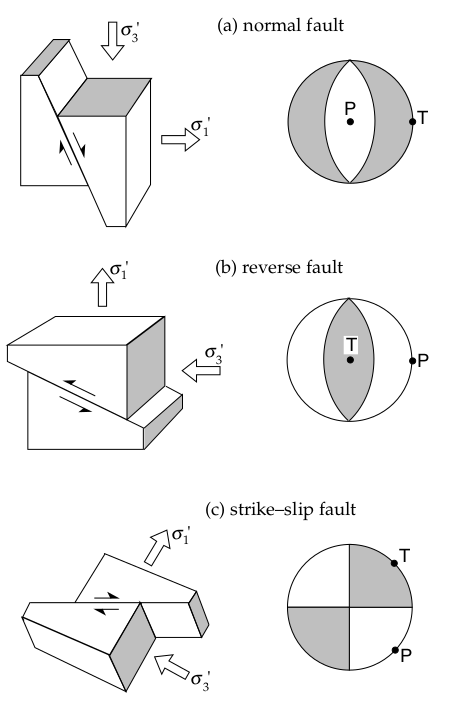


Moment tensor descriptions (L04, P48):
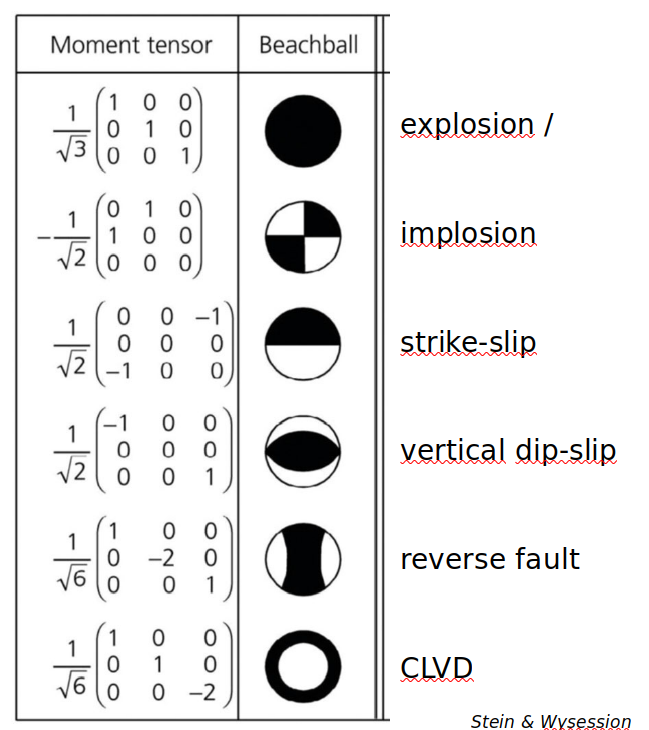




We will use several components of the pyrocko framework. Shown here is the scheme of components which can be used in the pyrocko framework for inversions (not all of them are used in this notebook)
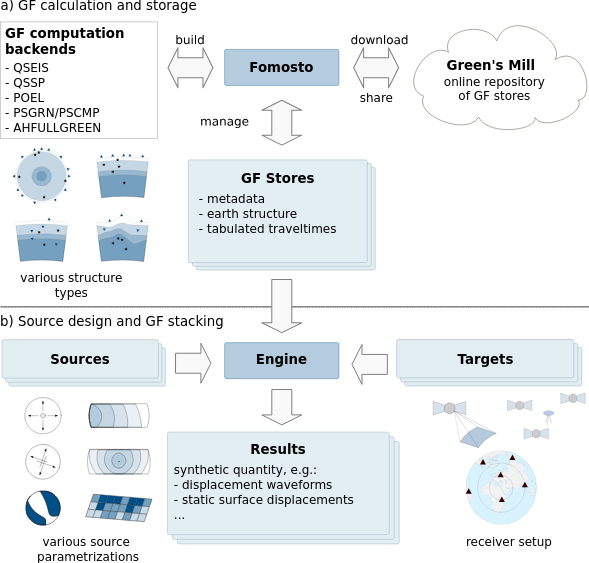

Lets import some functions:

In [1]:
%matplotlib inline
# Cell 1
import time
import os
import scipy
import numpy as num
import matplotlib.pyplot as plt
from collections import OrderedDict
import obspy
from pyrocko import obspy_compat
obspy_compat.plant()

# import helper functions
import utils_nb

# import functions from pyrocko directly for utility
from pyrocko import gf, trace
from pyrocko import moment_tensor as mtm
from pyrocko.gf import ws, LocalEngine, Target, DCSource
from pyrocko import util, pile, model, config, trace, io, pile, catalog

km = 1000.

### Get GlobalCMT Start Model
We use the GlobalCMT catalog (https://www.globalcmt.org/CMTsearch.html) to search for the 2009 Aquila Earthquake and initalize a source location and time for the starting model.

In [2]:
# Cell 2
tmin = util.str_to_time('2009-04-06 00:00:00')  # beginning time of query
tmax = util.str_to_time('2009-04-06 05:59:59')  # ending time of query
event = catalog.GlobalCMT().get_events(
    time_range=(tmin, tmax),
    magmin=6.)[0]

base_source = gf.MTSource.from_pyrocko_event(event)

### Initialize Forward Modelling Engine (Seismosizer)
 

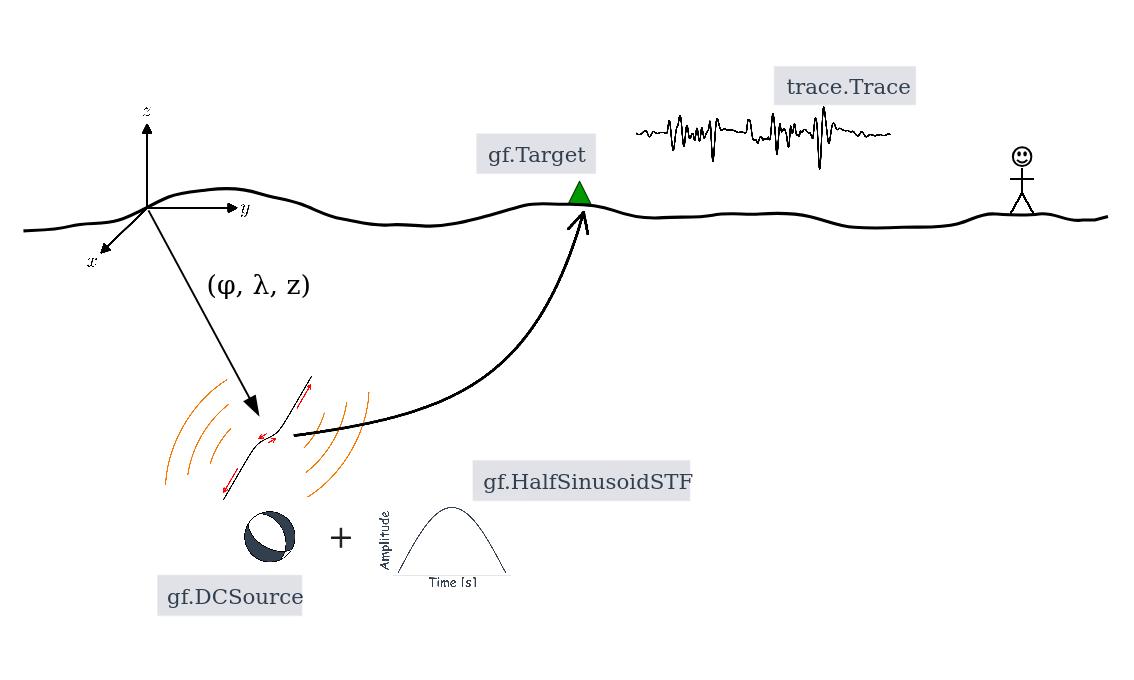

In [3]:
# Cell 3
# We download the precalculated Green's function database (`Store`) *global_2s_25km* from http://kinherd.org

store_id = 'global_2s_25km'
if not os.path.exists(store_id):
    ws.download_gf_store(site='kinherd', store_id=store_id)


Now we fire up the `engine` to forward model synthetic seismograms on our _global_2s_25km_ GF database.

In [4]:
# Cell 4
engine = gf.LocalEngine(store_superdirs=['.']) # The Path to where the gf_store(s)
store = engine.get_store(store_id)  # Load the store.

Let's use our source, stf and store to forward modell synthetic waveforms for one station:

In [5]:
# Cell 5
# Global CMT solution for L'Aquila event for location and time. 
#The source mechanism parameters are choosen at random here.
dc_source = gf.DCSource(
    lat=42.29, lon=13.35, depth=12*km, magnitude=6.3,
    time=util.str_to_time('2009-04-06 01:32:49.190'),
    strike=100.0, dip=90.0, rake=-180.0)

# Source-time function
laquila_stf = gf.TriangularSTF(duration=1.0)
# Update the Source with the choosen STF
dc_source.stf = laquila_stf
 
# Modelling targets (seismometer at BFO)
waveform_targets = []
for channel_code in ('BHE', 'BHN', 'BHZ'):
    target = gf.Target(
        lat=48.3301, lon=8.3296, elevation=638.0,
        codes=('II', 'BFO', '00', channel_code),
        quantity='velocity', store_id=store_id)
 
    waveform_targets.append(target)

    
response = engine.process(dc_source, waveform_targets)

syn_velocity_traces = response.pyrocko_traces()

# View synthetic seismograms
trace.snuffle(
    syn_velocity_traces, events=[dc_source.pyrocko_event()],
    stations=[x.pyrocko_station() for x in waveform_targets])


 /home/asteinbe/.snufflings/okada/libokada.so: cannot open shared object file: No such file or directory
--> run 'make' in okada snuffling directory <--


### Load the Waveforms
We download the instrument-corrected seismic waveforms and use a `pyrocko.pile` to manage the data.

In [6]:
# Cell 6
# Download the instrument-corrected 2009 Aquila Earthquake data
data_path = utils_nb.download_dir('aquila_realdata1/')
data = pile.make_pile([data_path])

obspy_stream = obspy_compat.to_obspy_stream(data) # Conversion to obspy stream. Not needed here, just for your convience
traces = data.all()  # retrieves the raw waveform data as a 2D `numpy.array`.
f_low = 0.1  # Hz, for a lowpass filter

for tr in traces:
    tr.lowpass(4, f_low)
    

selecting files... done. 58 files selected.
cc.py:pyrocko.pile              - WARNING  - Cannot read file '/home/asteinbe/src/pyrocko-notebooks/data/aquila_realdata/stations_short.txt': No SEED data detected (file: /home/asteinbe/src/pyrocko-notebooks/data/aquila_realdata/stations_short.txt)
cc.py:pyrocko.pile              - WARNING  - The following file caused problems and will be ignored:
/home/asteinbe/src/pyrocko-notebooks/data/aquila_realdata/stations_short.txt


### Optimisation Parameters
Setup of the optimisation parameters, as well as boundaries for the source parameters.

In [7]:
# Cell 7
component = 'Z'
taper = trace.CosFader(xfade=2.0)  # Cosine taper, 2s fade

phase = 'P' # Phase to fit
tmin_fit = 15. # [s] to fit before synthetic phase onset (from GFStore)
tmax_fit = 25. # [s] ... after

# Bounds of the inversion parameters for a DC source
bounds = OrderedDict([
    ('north_shift', (-20.*km, 20.*km)),
    ('east_shift', (-20.*km, 20.*km)),
    ('depth', (0.5*km, 14.*km)),
    ('magnitude', (6.2, 6.4)),
    ('strike', (0., 360.)),
    ('dip', (0., 90.)),
    ('rake', (-180, 180.)),
    ('timeshift', (-6.5, 2.)),
    ])


# # Bounds of the inversion parameters for a full MT source
bounds_MT = OrderedDict([
    ('north_shift', (-20.*km, 20.*km)),
    ('east_shift', (-20.*km, 20.*km)),
    ('depth', (0.5*km, 14.*km)),
    ('mnn', (-1e19, 1e19)),
    ('mee', (-1e19, 1e19)),
    ('mdd', (-1e19, 1e19)),
    ('mne', (-1e19, 1e19)),
    ('mnd', (-1e19, 1e19)),
    ('med', (-1e19, 1e19)),
    ('timeshift', (-6.5, 2.)),
    ])

### Station and _Target_ Setup
We use the term _Target_ for a single component of a single station.

In [8]:
# Cell 8
stations_list = model.load_stations('data/aquila_realdata/stations_short.txt')
for s in stations_list:
    s.set_channels_by_name(*component.split())
    
    
# Plot stations and event location:
def plot_stations():
    import folium
    fmap = folium.Map(
        location=[base_source.lat, base_source.lon],
        tiles='OpenStreetMap', attr="Laquila stations",
        zoom_start=1.5)
    folium.Marker([base_source.lat, base_source.lon],
        popup=('2009 Aquila Earthquake'),
        icon=folium.Icon(color='red', icon='info-sign')).add_to(fmap)
                  
    for s in stations_list:
        folium.Marker([s.lat, s.lon],
                      popup='<b>%s</b></h4>' % s.station).add_to(fmap)
    fmap.add_child(folium.LatLngPopup())
    return fmap
# If folium is not installed on your system, no plot will be generated.
try:
    plot_stations()
except:
    pass

Next we define the `Target` - where to calculate the synthetic seismogram.

In [9]:
# Cell 9
targets=[]
for s in stations_list:
    target = Target(
            lat=s.lat,
            lon=s.lon,
            store_id=store_id,   # The gf-store to be used for this target,
            interpolation='multilinear',  # Interpolation method between GFStore nodes
            quantity='displacement',
            codes=s.nsl() + ('BH' + component,))
    targets.append(target)

### Objective Function
Now the objective function that will be called by `scipy.optimize`(https://docs.scipy.org/doc/scipy/reference/optimize.html):

In [10]:
# Cell 10

# Init the surce
source = gf.DCSource(
    lat=event.lat,
    lon=event.lon)


sourceMT = gf.MTSource(
    lat=event.lat,
    lon=event.lon)

laquila_stf = gf.TriangularSTF(duration=10.0)

dc_source.stf = laquila_stf
sourceMT.stf = laquila_stf
# Task hint: Update the source inversion with a realistic stf by 
# replaceing the current laquila_stf a different STF function from pyrocko. 


# Now we define functions that will be called in each iterative step to update our source model with
# the inversion parameters
#
def update_mtsource(params):
    s = sourceMT
    s.north_shift = float(params[0])
    s.east_shift = float(params[1])
    s.depth = float(params[2])
    s.mnn = float(params[3])
    s.mee = float(params[4])
    s.mdd = float(params[5])
    s.mne = float(params[6])
    s.mnd = float(params[7])
    s.med = float(params[8])
    s.time = float(event.time - params[9])
    return sourceMT

def update_source(params):
    s = source
    s.north_shift = float(params[0])
    s.east_shift = float(params[1])
    s.depth = float(params[2])
    s.magnitude = float(params[3])
    s.strike = float(params[4])
    s.dip = float(params[5])
    s.rake = float(params[6])
    s.time = float(event.time - params[7])
    return source

# Define pre-processing for each trace
def process_trace(trace, tmin, tmax, lowpass=False, inplace=True):
    if lowpass:
        trace.lowpass(4, f_low)
    trace = trace.chop(tmin, tmax, inplace=inplace)
    trace.taper(taper)
    return trace

iiter = 0

# function that will be called during the inversion:
def trace_fit(params, line=None, MTsource=False):
    global iiter
    if MTsource == True:
        update_mtsource(params)
    else:
        update_source(params)

    # Forward model synthetic seismograms
    if MTsource == True:
        response = engine.process(sourceMT, targets)
    else:
        response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()

    misfits = 0.
    norms = 0.

    for obs, syn, target in zip(traces, syn_traces, targets):
        syn_phs = store.t(phase, base_source, target)
        
        tmin = base_source.time + syn_phs - tmin_fit  # start before theor. arrival
        tmax = base_source.time + syn_phs + tmax_fit  # end after theor. arrival
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=True)

        misfits += num.sqrt(num.sum((obs.ydata - syn.ydata)**2))
        norms += num.sqrt(num.sum(obs.ydata**2))
    # We define the objective function:

    misfit = num.sqrt(misfits**2 / norms**2)
    
    iiter += 1

    if line:
        data = {
            'y': [misfit],
            'x': [iiter],
        }
        line.data_source.stream(data)

    return misfit

#### Running the optimization and plotting of the Convergence
For plotting we use bokeh (which you might need to install: `pip3 install bokeh`)  
Jupyter Lab also requires the Bokeh extension: `jupyter labextension install jupyterlab_bokeh`  
More info at https://bokeh.pydata.org/en/latest/docs/user_guide/notebook.html

In [11]:
# Cell 11
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

f = figure(title='SciPy Optimisation Progress',
           x_axis_label='# Iteration',
           y_axis_label='Misfit')
plot = f.scatter([], [])
show(f, notebook_handle=True)

Loading BokehJS ...

### Optimisation with SciPy
We will use a evolutionary algorithm for the inversion, differential evolution (https://en.wikipedia.org/wiki/Differential_evolution) from `scipy.optimize.differential_evolution` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html)  to find a best fitting model. The method is stochastic in nature (does not use gradient methods) to find the minimium, and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient based techniques. 


modified description from scipy:

Differential evolution is a stochastic population based method that is useful for global optimization problems. At each pass through the population the algorithm mutates each candidate solution by mixing with other candidate solutions to create a trial candidate. There are several strategies for creating trial candidates, which suit some problems more than others. The ‘best1bin’ strategy is a good starting point for many systems. In this strategy two members of the population are randomly chosen. Their difference is used to mutate the best member (the ‘best’ in ‘best1bin’), 
, so far:

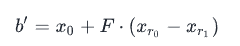

where F 
 is the mutation parameter. A trial vector is then constructed. Starting with a randomly chosen ith parameter the trial is sequentially filled with parameters from b' or the original candidate. The choice of whether to use b' or the original candidate is made with a binomial distribution (the ‘bin’ in ‘best1bin’) - a random number in [0, 1) is generated. If this number is less than the recombination constant then the parameter is loaded from b', otherwise it is loaded from the original candidate. The final parameter is always loaded from b'. Once the trial candidate is built its fitness is assessed. If the trial is better than the original candidate then it takes its place. If it is also better than the best overall candidate it also replaces that.
 "

The scipy solver can easily be exchanged for a method of your favor. If you just want a quick demonstration, you can change the number of maxiter in the solve function to something lower.

In [23]:
# Cell 12
# Solve for a DC source
MTsource = False
def solve():
    t = time.time()
    result = scipy.optimize.differential_evolution(
        trace_fit,
        args=[plot, MTsource],
        bounds=tuple(bounds.values()),
        maxiter=1500000,
        tol=0.0001,
        callback=lambda a, convergence: push_notebook())

    source = update_source(result.x)
   # source.regularize()

    print("Time elapsed: %.1f s" % (time.time() - t))
    print("Best model:\n - Misfit %f" % trace_fit(result.x))
    print(source)
    return result, source


# Start the optimisation
result, best_source = solve()
dcsource = update_source(result.x)

Time elapsed: 160.9 s
Best model:
 - Misfit 0.668866
--- !pf.DCSource
lat: 42.29
lon: 13.35
north_shift: -8.844760679436181
east_shift: 8990.295353985304
depth: 705.8725270212726
time: '2009-04-06 01:32:51.033860922'
stf_mode: post
magnitude: 6.2147461656844705
strike: 136.99187940700358
dip: 44.49761607632913
rake: -82.14968007482771



Alternatively we can invert for a full Moment Tensor: 

In [12]:
# Cell 13
# Solve for a full MT source
MTsource = True
def solve():
    t = time.time()
    result = scipy.optimize.differential_evolution(
        trace_fit,
        args=[plot, MTsource],
        bounds=tuple(bounds_MT.values()),
        maxiter=1500000,
        tol=0.0001,
        callback=lambda a, convergence: push_notebook())

    mtsource = update_mtsource(result.x)

    print("Time elapsed: %.1f s" % (time.time() - t))
 #   print("Best model:\n - Misfit %f" % trace_fit(result.x, MTsource))
    print(mtsource)
    return result, mtsource


# Start the optimisation
result_mt_source, best_source_mt = solve()
mtsource = update_mtsource(result_mt_source.x)
                           

Time elapsed: 371.8 s
--- !pf.MTSource
lat: 42.29
lon: 13.35
north_shift: 11074.715814403899
east_shift: 2748.950599493993
depth: 1686.4434045237704
time: '2009-04-06 01:32:50.415285587'
stf: !pf.TriangularSTF
  duration: 10.0
  peak_ratio: 0.5
  anchor: 0.0
stf_mode: post
mnn: 8.926595443581409e+17
mee: 1.0118185202068997e+18
mdd: -4.012940824712552e+18
mne: 1.1511238085365605e+18
mnd: -3.028976404880801e+17
med: 1.341052134669285e+17



In [ ]:
# Cell 14
# Print the decomposition of the moment tensor. 
# The format is:
#(moment_iso, ratio_iso, m_iso),
#(moment_dc, ratio_dc, m_dc),
#(moment_clvd, ratio_clvd, m_clvd),
#(moment_devi, ratio_devi, m_devi),
#(moment, 1.0, m)

print("Decomposition:", mtsource.pyrocko_moment_tensor().standard_decomposition())

# Print the total moment of the source                         
print("Total moment:", mtsource.pyrocko_moment_tensor().moment)

# Print the deviatoric moment of the source                         
print("Deviatoric moment:", mtsource.pyrocko_moment_tensor().deviatoric().moment)

Compare with: https://earthquake.usgs.gov/earthquakes/eventpage/usp000gvtu/moment-tensor

### Plot the Results
Now we plot the synthetic waveforms produced by our the best model vs. the observed traces. Note that jupyter notebook is sequential and as written here, only the results for the last run inversion will be shown (which can either be DC or MT source!)

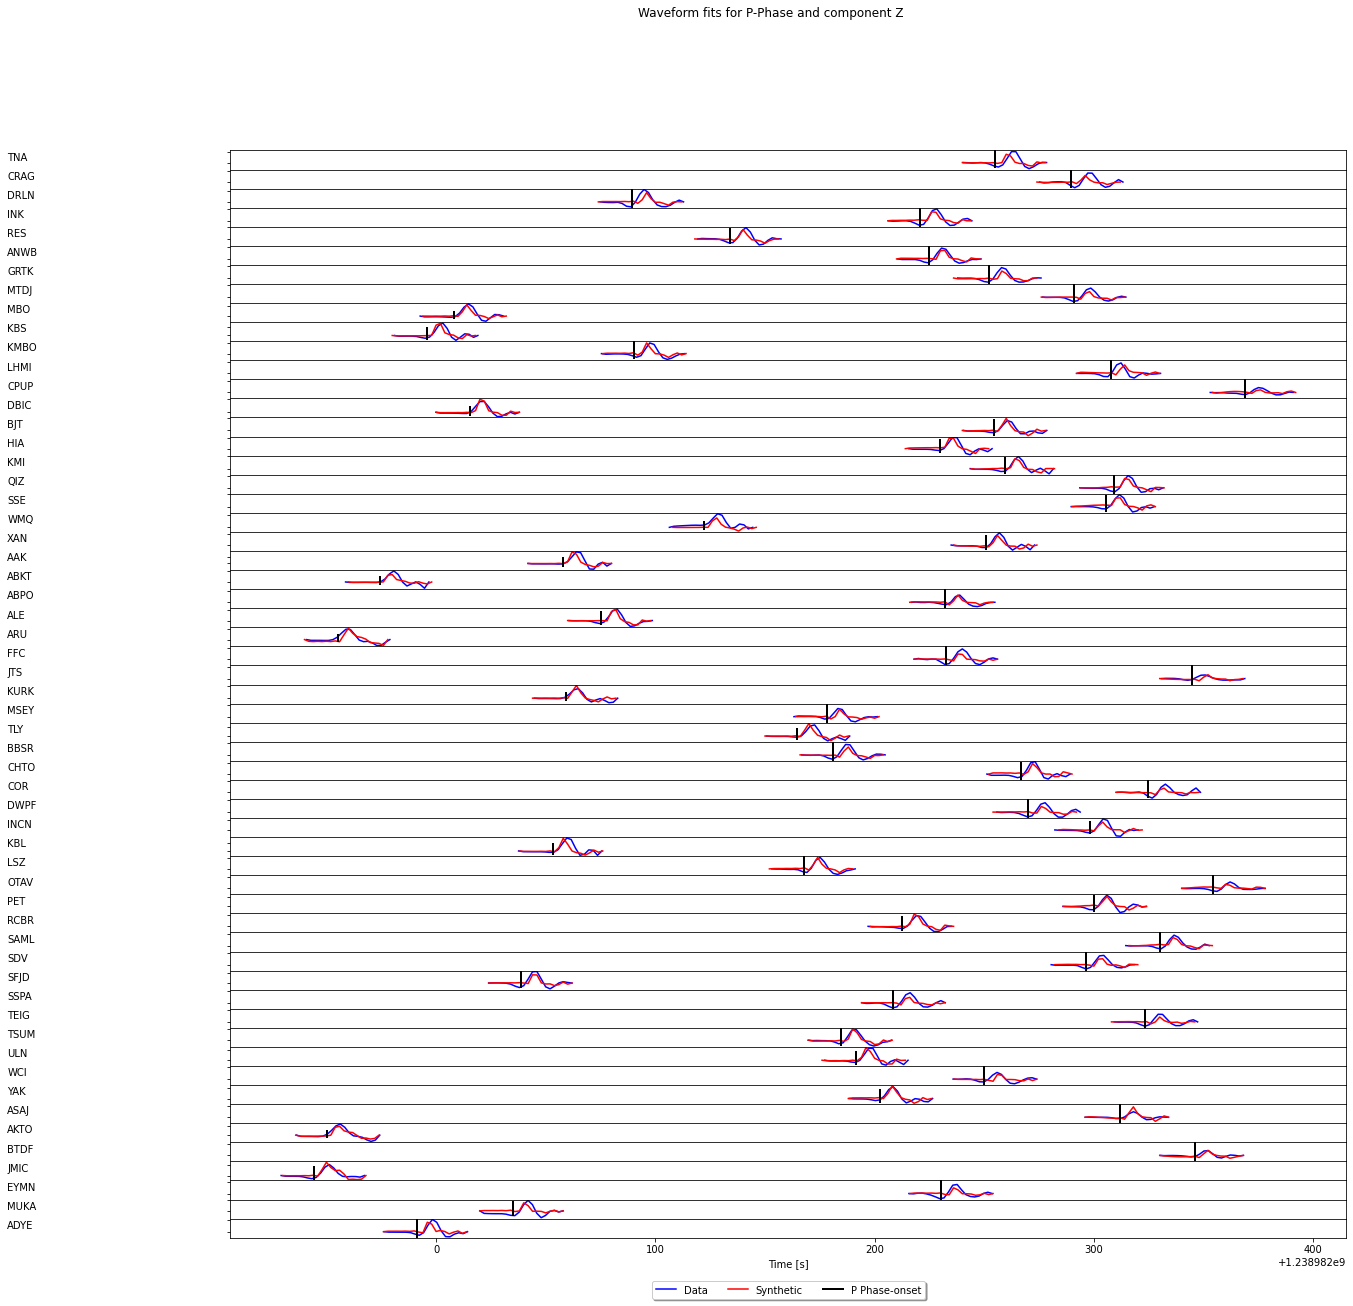

In [24]:
# Cell 15
def plot_traces(result, MTsource=False):
    nstations = len(stations_list)
    if MTsource == True:
        response = engine.process(mtsource, targets)
    else:
        response = engine.process(source, targets)
    
    syn_traces = response.pyrocko_traces()

    fig, axes = plt.subplots(nstations, squeeze=True, sharex=True, figsize=(20,20))
    fig.subplots_adjust(hspace=0)
    plt.setp([ax.get_xticklabels() for ax in axes[:-1]], visible=False)

    for istation, (obs, syn, target) in enumerate(zip(traces, syn_traces, targets)):
        ax = axes[istation]
        tp = store.t(phase, base_source, target)
        tp_onset = base_source.time + tp
        tmin = tp_onset - tmin_fit
        tmax = tp_onset + tmax_fit
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)
        
        s1 = ax.plot(obs.get_xdata(), obs.ydata, color='b')
        s2 = ax.plot(syn.get_xdata(), syn.ydata, color='r')
        s3 = ax.plot([tp_onset, tp_onset], [tr.ydata.min(), tr.ydata.max()], 'k-', lw=2)

        ax.text(-.2, 0.5, stations_list[istation].station,
                transform=ax.transAxes)
        ax.set_yticklabels([], visible=False)

    axes[-1].set_xlabel('Time [s]')
    plt.suptitle('Waveform fits for %s-Phase and component %s' % (phase, component))
    plt.legend(
        (s1[0], s2[0], s3[0]),
        ('Data', 'Synthetic','%s Phase-onset' % phase),
        loc='upper center',
        bbox_to_anchor=(0.5, -2.),
        fancybox=True, shadow=True, ncol=5)
    
    plt.show()
MTsource = False

plot_traces(result, MTsource)

Alternatively we can look at the waveforms interactivly with snuffler: 

In [25]:
# Cell 16
def plot_snuffler(result, source):
    engine = gf.get_engine(["."])
    response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()
    obs_traces = []
    
    for obs, syn, target in zip(traces, syn_traces, targets):
        tp = store.t('P', base_source, target)
        tmin = base_source.time + tp - tmin_fit
        tmax = base_source.time + tp + tmax_fit

        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)

        obs_traces.append(obs)

    trace.snuffle(obs_traces + syn_traces, stations=stations_list, events= [event])
plot_snuffler(result, best_source)

cc.py:pyrocko.gui.snuffling.okada - WARNING  - 
 /home/asteinbe/.snufflings/okada/libokada.so: cannot open shared object file: No such file or directory
--> run 'make' in okada snuffling directory <--


Plot the resulting source mechanism and the piercing points of the stations used in the inversion.

In [21]:
# Cell 17
from pyrocko import moment_tensor as pmt, cake, orthodrome
from pyrocko.plot import beachball

size = 1
offset = 2.1

def plot_source_result_piercing_points(inverted_source, stations_list, store):
    # source position and mechanism
    slat, slon, sdepth = inverted_source.lat, inverted_source.lon, inverted_source.depth        
    mtvals = inverted_source.pyrocko_moment_tensor()

    # receiver positions
    rdepth = 0.0
    rlatlons = []
    for station in stations_list:
        rlatlons.append((station.lat, station.lon))

    # earth model and phase for takeoff angle computations

    store = engine.get_store(store_id)
    mod = store.config.earthmodel_1d
    phases = cake.PhaseDef.classic('P')
    
    # setup figure with aspect=1.0/1.0, ranges=[-1.1, 1.1]
    fig = plt.figure(figsize=(10., 10.))  # size in inch
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
    axes = fig.add_subplot(1, 1, 1, aspect=1.0)
    axes.set_axis_off()
    axes.set_xlim(-1.1, 3.5)
    axes.set_ylim(-1.1, 1.1)

    projection = 'lambert'

    beachball.plot_beachball_mpl(
        mtvals, axes,
        position=(0., 0.),
        size=size,
        color_t=(0.7, 0.4, 0.4),
        projection=projection,
        size_units='data')

    for rlat, rlon in rlatlons:
        distance = orthodrome.distance_accurate50m(slat, slon, rlat, rlon)
        rays = mod.arrivals(
            phases=cake.PhaseDef('P'),
            zstart=sdepth, zstop=rdepth, distances=[distance*cake.m2d])

        if not rays:
            continue

        takeoff = rays[0].takeoff_angle()
        azi = orthodrome.azimuth(slat, slon, rlat, rlon)

        # to spherical coordinates, r, theta, phi in radians
        rtp = num.array([[size, num.deg2rad(takeoff), num.deg2rad(90.-azi)]])

        # to 3D coordinates (x, y, z)
        points = beachball.numpy_rtp2xyz(rtp)

        # project to 2D with same projection as used in beachball
        x, y = beachball.project(points, projection=projection).T
        axes.plot(x, y, 'X', ms=10., mew=2.0, mec='black', mfc='none')

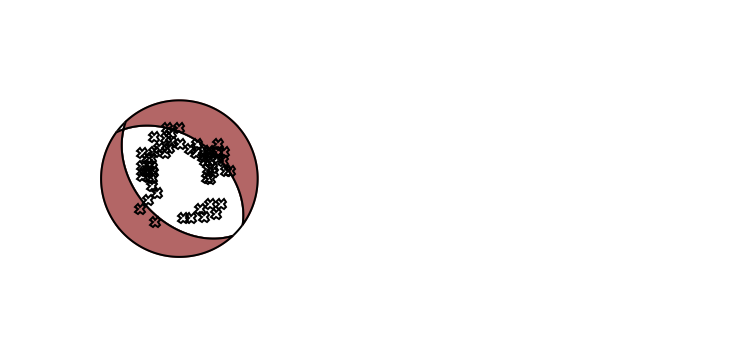

In [26]:
# Cell 18
# Plot the solution for the double couple:

plot_source_result_piercing_points(dcsource, stations_list, engine)

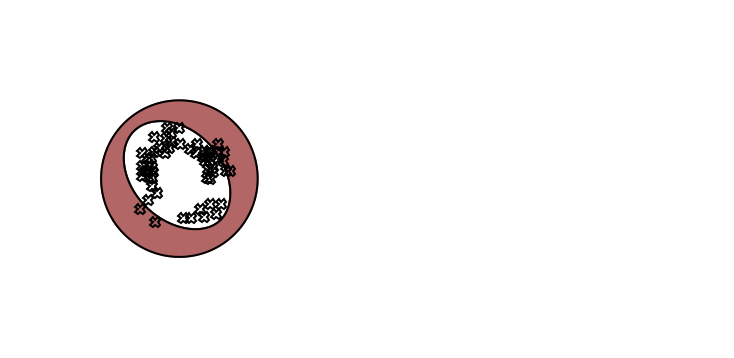

In [22]:
# Cell 19
# Plot the solution for the full moment tensor:
plot_source_result_piercing_points(mtsource, stations_list, engine)

Tasks for E05:

1. During initialization of the forward problem, we have defined a triangular stf (cell 10, Lines 13-16). Run the inversion again with a different, more realistic stf and explain why you used this. You can use resources like the scardec catalog to obtain a stf duration estimate (http://scardec.projects.sismo.ipgp.fr/#). Available stfs in pyrocko are: BoxcarSTF, TriangularSTF, HalfSinusoidSTF, ResonatorSTF, TremorSTF, and SimpleLandslideSTF( https://data.pyrocko.org/presentations/pyrocko-workshop-dgg-2021/#/4/7 for more hints). Compare the resulting moment tensor parameters of the two solutions and explain the differences.

2. In cell 10 (objective function) two different sources are defined, a DC and a full MT source. In cell 12 (optimization), so far, we have solved for the DC source only. Now, repeat the inversion for the full MT source. How large are the percentages of double-couple, isotropic, and CLVD parts of the now resulting moment tensor. Do you think the results are realistisc? How would they be different if this would not have been an earthquake but an explosion?

3. Consider the underlying assumptions of the point source approximation again. What advantages does it have to use stations in the far-field? Which source parameters of a realistic earthquake scenario can not be resoled?